In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

import sys

!ls /content/gdrive/MyDrive/Colab\ Notebooks

sys.path.append('/content/gdrive/MyDrive/Colab Notebooks/L2D-reinforcement_learning/lib')

Mounted at /content/gdrive
agents_nt.py					L2D-reinforcement_learning
BIOS0040-CPS-10-frozen-lake.ipynb		__pycache__
BIOS0040-CPS-10-frozen-lake_solution.ipynb	utils_nt.py
BIOS0040-Week-10-practical-cliff-walking.ipynb	W10_lecture1.pptx


In [2]:
!pip install gymnasium[classic_control]
!pip install torch
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install pyvirtualdisplay > /dev/null 2>&1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 879 kB 6.1 MB/s 
     |████████████████████████████████| 13.7 MB 60.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import gymnasium as gym
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay

import os
from DQN_agent_nt import Agent
from utils_nt import plot_value, plot_returns, plot_explore
from bioreactor_env_nt import BioreactorEnv, xdot_control, monod, target_reward

import numpy as np
import matplotlib.pyplot as plt
import math
import random
from collections import namedtuple, deque
 
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
class QNetwork(nn.Module):
    """ Actor (Policy) Model."""
    def __init__(self, state_size,action_size, layer1_size=64,
                 layer2_size = 64):
        """
        Initialize parameters and build model.
        Params
        =======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            layer1_size (int): Number of nodes in first hidden layer
            layer2_size (int): Number of nodes in second hidden layer
        """
        super(QNetwork,self).__init__() ## calls __init__ method of nn.Module class
        self.layer1= nn.Linear(state_size,layer1_size)
        self.layer2 = nn.Linear(layer1_size,layer2_size)
        self.layer3 = nn.Linear(layer2_size,action_size)

    def forward(self,x):
        # x = state
        """
        Build a network that maps state -> action values.
        """
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)


class ReplayBuffer:
  """Fixed -size buffe to store experience tuples."""

  def __init__(self, action_size, buffer_size, batch_size):
      """Initialize a ReplayBuffer object.

      Params
      ======
          action_size (int): dimension of each action
          buffer_size (int): maximum size of buffer
          batch_size (int): size of each training batch
      """

      self.action_size = action_size
      self.memory = deque(maxlen=buffer_size)
      self.batch_size = batch_size
      self.experiences = namedtuple("Experience", field_names=["state",
                                                              "action",
                                                              "reward",
                                                              "next_state",
                                                              "done"])
 

  def add(self,state, action, reward, next_state,done):
      """Add a new experience to memory."""
      e = self.experiences(state,action,reward,next_state,done)
      self.memory.append(e)

  def sample(self):
      """Randomly sample a batch of experiences from memory"""
      experiences = random.sample(self.memory,k=self.batch_size)

      states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
      actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).long().to(device)
      rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
      next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
      dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

      return (states,actions,rewards,next_states,dones)
  def __len__(self):
      """Return the current size of internal memory."""
      return len(self.memory)




BUFFER_SIZE = int(1e5)  #replay buffer size
BATCH_SIZE = 64         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR = 5e-4               # learning rate
UPDATE_EVERY = 4        # how often to update the network


class DQN_agent():
    """Interacts with and learns form environment."""

    def __init__(self, state_size, action_size):
        """Initialize an Agent object.

        Params
        =======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            seed (int): random seed
        """

        self.state_size = state_size
        self.action_size = action_size
       
        #Q- Network
        self.qnetwork = QNetwork(state_size, action_size).to(device)
        self.qnetwork_target = QNetwork(state_size, action_size).to(device)

        self.optimizer = optim.Adam(self.qnetwork.parameters(),lr=LR)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE,BATCH_SIZE)
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0

   
        
    def policy(self, state, eps = 0):
        """Returns action for given state as per current policy
        Params
        =======
            state (array_like): current state
            eps (float): epsilon, for epsilon-greedy action selection
        """
 
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        self.qnetwork.eval()
        with torch.no_grad():
            action_values = self.qnetwork(state)
        self.qnetwork.train()

        #Epsilon -greedy action selction
        if random.random() > eps:
            return np.argmax(action_values.cpu().data.numpy())
        else:
            return random.choice(np.arange(self.action_size))

    def update_Q(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.
        Params
        =======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        
        criterion = torch.nn.MSELoss()
        # Local model is one which we need to train so it's in training mode
        self.qnetwork.train()
        # Target model is one with which we need to get our target so it's in evaluation mode
        # So that when we do a forward pass with target model it does not calculate gradient.
        # We will update target model weights with soft_update function
        self.qnetwork_target.eval()
        #shape of output from the model (batch_size,action_dim) = (64,4)
        predicted_targets = self.qnetwork(states).gather(1,actions)

        with torch.no_grad():
            labels_next = self.qnetwork_target(next_states).detach().max(1)[0].unsqueeze(1)

        # .detach() ->  Returns a new Tensor, detached from the current graph.
        labels = rewards + (gamma* labels_next*(1-dones))

        loss = criterion(predicted_targets,labels).to(device)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # ------------------- update target network ------------------- #
        self.update_target(self.qnetwork,self.qnetwork_target,TAU)

    def update_target(self, model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        =======
            local model (PyTorch model): weights will be copied from
            target model (PyTorch model): weights will be copied to
            tau (float): interpolation parameter
        """
        for target_param, local_param in zip(target_model.parameters(),
                                           model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1-tau)*target_param.data)
    
    def get_explore_rate(self, episode, decay, min_r = 0, max_r = 1):
        '''
        Calculates the logarithmically decreasing explore or learning rate

        Parameters:
            episode: the current episode
            MIN_LEARNING_RATE: the minimum possible step size
            MAX_LEARNING_RATE: maximum step size
            denominator: controls the rate of decay of the step size
        Returns:
            step_size: the Q-learning step size
        '''

        # input validation
        if not 0 <= min_r <= 1:
            raise ValueError("MIN_LEARNING_RATE needs to be bewteen 0 and 1")

        if not 0 <= max_r <= 1:
            raise ValueError("MAX_LEARNING_RATE needs to be bewteen 0 and 1")

        if not 0 < decay:
            raise ValueError("decay needs to be above 0")

        rate = max(min_r, min(max_r, 1.0 - math.log10((episode + 1) / decay)))

        return rate
            

In [6]:



def train_DQN(agent, env, n_episodes= 200, max_t = 1000, eps_start=1.0, eps_end = 0.01,
       eps_decay=0.996, display = False):
    """Deep Q-Learning
    
    Params
    ======
        n_episodes (int): maximum number of training epsiodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon 
        eps_decay (float): mutiplicative factor (per episode) for decreasing epsilon
        
    """
    returns = [] # list containing score from each episode
  
    

    if display:
      display = Display(visible=0, size=(400, 300))
      display.start()

    for episode in range(1, n_episodes+1):

        explore_rate = agent.get_explore_rate(episode, n_episodes/11)
        state, prob = env.reset()

        
        

        if display:
          img = plt.imshow(env.render()) # only call this once
          plt.imshow(env.render())
      
        ret = 0
        for t in range(max_t):
         
            action = agent.policy(state,explore_rate)
            next_state, reward, done, info, prob = env.step(action)
            
            if display:
              #img.set_data(env.render())
              plt.imshow(env.render())
              ipythondisplay.clear_output(wait=True)
              ipythondisplay.display(plt.gcf())
            

            agent.memory.add(state, action, reward, next_state, done)


            # Learn every UPDATE_EVERY time steps.
           
            if t% UPDATE_EVERY == 0:
                # If enough samples are available in memory, get random subset and learn
                if len(agent.memory)>BATCH_SIZE:
                    experience = agent.memory.sample()
                    agent.update_Q(experience, GAMMA)

                
            state = next_state
            ret += reward
            if done:
                break
            
    
        returns.append(ret) 
        if episode %10==0:
          print('\rEpisode {}\tExplore rate {}\tReturn {:.2f}\t '.format(episode, explore_rate, ret))
    if display:
      ipythondisplay.clear_output(wait=True) 
    return returns



## Bioreactor

In [ ]:
def reward_f(x):
    '''
    caluclates the reward based on the rate of product output
    :param x:
    :return:
    '''
    P = x[-1]


    if x[0] < 1000 or x[1] < 1000:
        reward = -1
        done = True
    else:
        reward = P/100000
        done = False

    return reward, done


def xdot_product(x, t, u):
    '''
    Calculates and returns derivatives for the numerical solver odeint

    Parameters:
        S: current state
        t: current time
        Cin: array of the concentrations of the auxotrophic nutrients and the
            common carbon source
        params: list parameters for all the exquations
        num_species: the number of bacterial populations
    Returns:
        xdot: array of the derivatives for all state variables
    '''
    q = 0.5
    y, y0, umax, Km, Km0 = [np.array(x) for x in [[480000., 480000.], [520000., 520000.], [1., 1.1], [0.00048776, 0.000000102115], [0.00006845928, 0.00006845928]]]

    # extract variables
    N = x[:2]
    C = x[2:4]
    C0 = x[4]
    A = x[5]
    B = x[6]
    P = x[7]

    R = monod(C, C0, umax, Km, Km0)

    # calculate derivatives
    dN = N * (R - q)  # q term takes account of the dilution
    dC = q * (u - C) - (1 / y) * R * N
    dC0 = q*(0.1 - C0) - sum(1/y0[i]*R[i]*N[i] for i in range(2))

    dA = N[0] - 2 * A ** 2 * B - q * A
    dB = N[1] - A ** 2 * B - q * B
    dP = A ** 2 * B - q * P

    # consstruct derivative vector for odeint
    xdot = np.append(dN, dC)
    xdot = np.append(xdot, dC0)
    xdot = np.append(xdot, dA)
    xdot = np.append(xdot, dB)
    xdot = np.append(xdot, dP)


    return xdot

num_controlled_species = 2

sampling_time = 10  # minutes
n_episodes = 1000

t_steps = int((24 * 60) / sampling_time)  # set this to 24 hours

initial_x = np.array([20000, 30000, 0., 0., 1., 0., 0., 0.]) # the initial state

env = BioreactorEnv(xdot_product, reward_f, sampling_time,
                    num_controlled_species, initial_x, t_steps, continuous_s = True)  # initalise the chemostat environment

n_states = 2
n_actions = 4
agent = DQN_agent(n_states, n_actions)
n_episodes = 1000
# train the agent
returns = train_DQN(agent, env, n_episodes)



/usr/local/lib/python3.8/dist-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


Episode 10	Explore rate 1	Return 27.92	 
Episode 20	Explore rate 1	Return 24.99	 
Episode 30	Explore rate 1	Return 30.30	 
Episode 40	Explore rate 1	Return 30.28	 
Episode 50	Explore rate 1	Return 28.13	 
Episode 60	Explore rate 1	Return 28.16	 
Episode 70	Explore rate 1	Return 33.66	 
Episode 80	Explore rate 1	Return 25.00	 
Episode 90	Explore rate 0.9995659225206813	Return 22.96	 
Episode 100	Explore rate 0.9542859410591324	Return 32.22	 
Episode 110	Explore rate 0.9132843360551175	Return 27.59	 
Episode 120	Explore rate 0.8758219445253249	Return 34.03	 
Episode 130	Explore rate 0.8413360191860106	Return 33.65	 
Episode 140	Explore rate 0.8093882021863951	Return 34.53	 
Episode 150	Explore rate 0.7796303675486056	Return 30.62	 
Episode 160	Explore rate 0.7517814388099252	Return 36.15	 
Episode 170	Explore rate 0.7256112044496211	Return 34.40	 
Episode 180	Explore rate 0.7009287399725904	Return 35.43	 
Episode 190	Explore rate 0.6775739475940474	Return 38.31	 
Episode 200	Explore rate

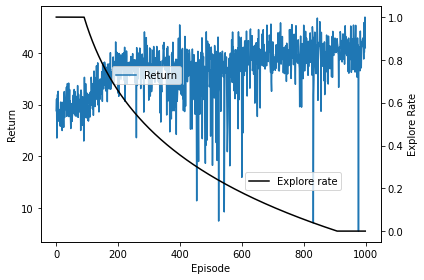

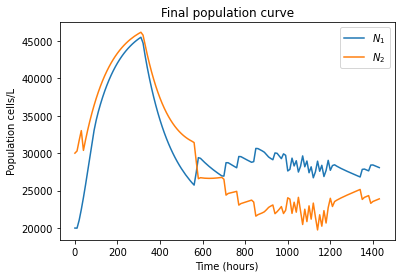

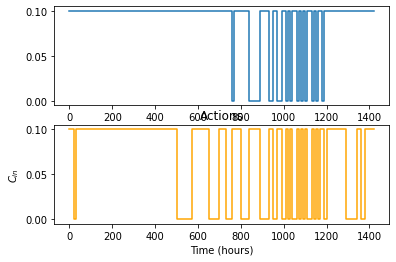

In [ ]:
# plot results
fig, ax1 = plt.subplots()

plt.plot(returns, label='Return')
explore_rates = [agent.get_explore_rate(episode, n_episodes / 11) for episode in range(n_episodes)]
ax1.set_ylabel('Return')
ax1.set_xlabel('Episode')
ax2 = ax1.twinx()
ax2.plot(explore_rates, color='black', label='Explore rate')
ax2.set_ylabel('Explore Rate')
ax2.set_xlabel('Episode')
plt.tight_layout()
ax1.legend(loc=(0.21, 0.67))
ax2.legend(loc=(0.6, 0.22))


plt.figure()
plt.title('Final population curve')
plt.plot(np.arange(len(env.xs)) *sampling_time, [x[0] for x in env.xs], label = '$N_1$')
plt.plot(np.arange(len(env.xs)) *sampling_time, [x[1] for x in env.xs], label = '$N_2$')
plt.legend()
plt.xlabel('Time (hours)')
plt.ylabel('Population cells/L')

fig, axs = plt.subplots(2,1)
plt.title('Actions')
axs[0].step(np.arange(len(env.us)) * sampling_time, [x[0] for x in env.us], label = '$u_1$')
axs[1].step(np.arange(len(env.us)) * sampling_time, [x[1] for x in env.us], label = '$u_2$', color = 'orange')

plt.xlabel('Time (hours)')
plt.ylabel('$C_{in}$')

plt.show()